Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
100%|██████████| 1000/1000 [00:04<00:00, 231.23it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7042233020428333, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [pot1]
100%|███

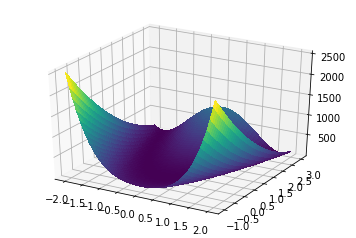

In [6]:
%pylab inline
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import numpy as np
import pymc3 as pm


def cust_logp(z):
    return -(1. - z[0])**2 - 100. * (z[1] - z[0]**2)**2


grid = np.mgrid[-2:2:100j, -1:3:100j]
Z = -np.asarray([cust_logp(g) for g in grid.reshape(2, -1).T])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(grid[0], grid[1], Z.reshape(100, 100), cmap='viridis',
                       linewidth=0, antialiased=False)

with pm.Model() as m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    tr1 = pm.sample(500, step=pm.NUTS())
    tr2 = pm.sample(500, step=pm.Metropolis())
    tr3 = pm.fit(n=40000, method='fullrank_advi').sample(
        500)  # VI, cause whynot

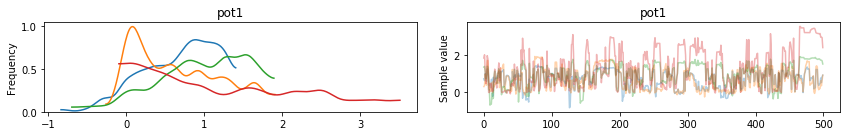

In [7]:
pm.traceplot(tr1);

In [32]:
pm.summary(tr1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,0.819905,0.540326,0.039663,-0.081128,1.84958,39.368058,1.075633
pot1__1,0.965480,0.872722,0.066751,-0.130710,2.81614,12.175608,1.124301


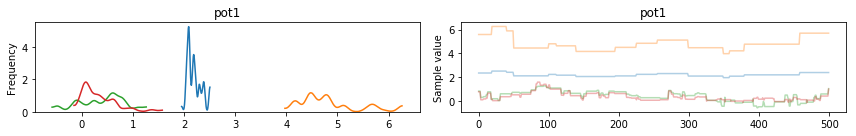

In [8]:
pm.traceplot(tr2);

In [33]:
pm.summary(tr2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,1.289713,0.956588,0.095091,-0.172782,2.50597,1.090764,4.084028
pot1__1,2.572763,2.282665,0.228028,-0.058268,5.69747,1.031528,6.864195


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
100%|██████████| 2500/2500 [00:09<00:00, 255.86it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


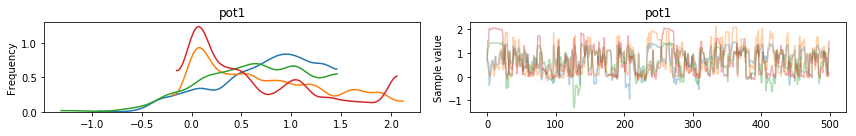

In [19]:
with m:
    tr4 = pm.sample(tune=2000)

pm.traceplot(tr4);

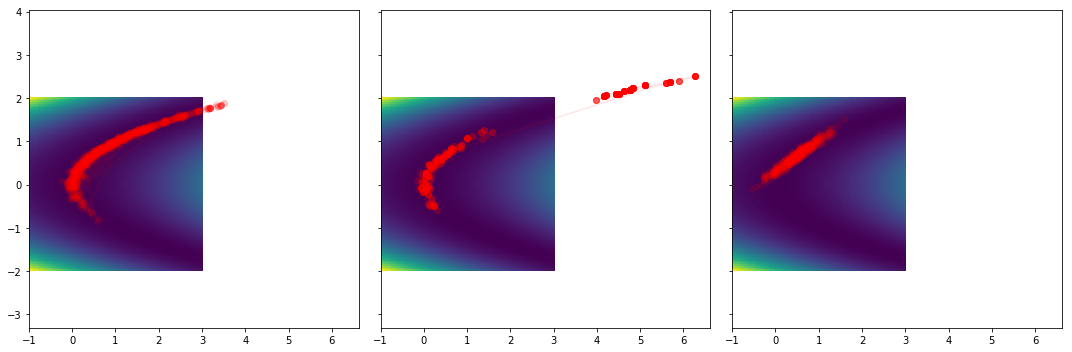

In [11]:
import matplotlib.pylab as plt
_, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[0].plot(tr1['pot1'][:, 1], tr1['pot1'][:, 0], 'ro-', alpha=.1)
ax[1].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[1].plot(tr2['pot1'][:, 1], tr2['pot1'][:, 0], 'ro-', alpha=.1)
ax[2].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[2].plot(tr3['pot1'][:, 1], tr3['pot1'][:, 0], 'ro', alpha=.1)
plt.tight_layout()

In [12]:
with pm.Model():
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    minimal=pm.find_MAP()
minimal

logp = -0.00017766, ||grad|| = 0.58277: 100%|██████████| 26/26 [00:00<00:00, 3539.84it/s]


{'pot1': array([0.99999971, 0.9999994 ])}

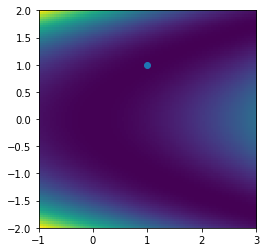

In [17]:
plt.imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
plt.plot(minimal['pot1'][0], minimal['pot1'][1], 'o');

# Basic HMC

In [20]:
with m:
    hmc = pm.HamiltonianMC()

def showstep(hmc, q0, model, epsilon=.025, n_steps=20):
    size = model.ndim
    hmc.integrator._logp_dlogp_func.set_extra_values({})

    post_evo = np.zeros((n_steps+1, size))
    post_evo[0, :] = q0

    p0 = hmc.potential.random()
    start = hmc.integrator.compute_state(q0, p0)

    state = start
    for i in range(n_steps):
        state = hmc.integrator.step(epsilon, state)
        post_evo[i+1, :]=state.q
    energy_change = start.energy - state.energy
    return energy_change, state, start, post_evo

    
q0 = pm.floatX(np.asarray([-1, 2]))
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
print(start)
print(state)

State(q=array([-1.,  2.]), p=array([-1.63815089, -0.59244307]), v=array([-1.63815089, -0.59244307]), q_grad=array([-396., -200.]), energy=105.51726357039072)
State(q=array([ 0.486591 , -0.7141983]), p=array([-4.78695066, -0.01231744]), v=array([-4.78695066, -0.01231744]), q_grad=array([-184.06638273,  190.1938193 ]), energy=102.1553352118775)


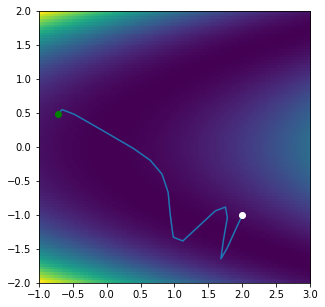

In [21]:
metrop_select = pm.step_methods.arraystep.metrop_select

def plotpost(energy_change, state, start, post_evo):
    q, accept = metrop_select(energy_change, state.q, start.q)
    colorall = ['r', 'g']
    _, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(Z.reshape(100,100), extent=[-1,3,-2,2,])
    ax.plot(post_evo[:, 1], post_evo[:, 0]);
    ax.plot(post_evo[0, 1], post_evo[0, 0], 'wo');
    ax.plot(post_evo[-1, 1], post_evo[-1, 0], 'o', color=colorall[accept]);
    return q
q1 = plotpost(energy_change, state, start, post_evo)

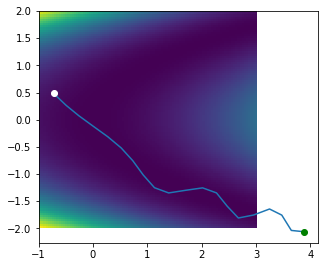

In [22]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

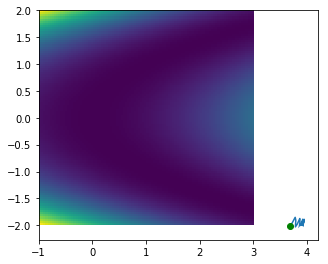

In [23]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

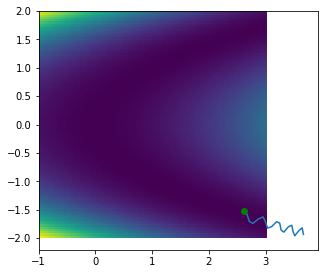

In [24]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

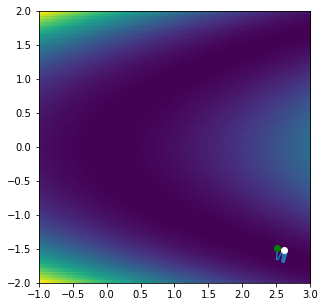

In [25]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

In [26]:
with m:
    hmc = pm.HamiltonianMC(path_length=.5, step_scale=.025)

In [27]:
hmc._hamiltonian_step(start, q0, hmc.step_size)

HMCStepData(end=State(q=array([-1.53853298,  2.61820425]), p=array([-2.29446199, -0.20146138]), v=array([-2.29446199, -0.20146138]), q_grad=array([-149.4658087 ,  -50.22410189]), energy=15.402871989136194), accept_stat=1, divergence_info=None, stats={'path_length': 0.03311309418831676, 'n_steps': 1, 'accepted': True, 'energy': 15.402871989136194, 'energy_error': 0.45166679912744634, 'accept': 1})

In [28]:
int(hmc.path_length / hmc.step_size)

23

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [pot1]
100%|██████████| 500/500 [00:00<00:00, 763.83it/s]
The acceptance probability does not match the target. It is 0.9775346230819694, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


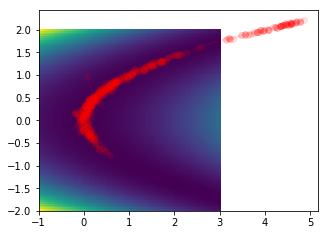

In [30]:
with m:
    trh = pm.sample(500, step=hmc, tune=0, chains=1,
                    start=dict(pot1=np.asarray([-1, 2])))

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax.plot(trh['pot1'][:, 1], trh['pot1'][:, 0], 'ro-', alpha=.1);

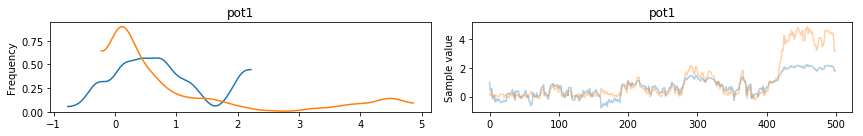

In [31]:
pm.traceplot(trh);

# Tree building in NUTS

In [14]:
with m:
    nuts = pm.NUTS()

In [80]:
nuts.integrator._logp_dlogp_func.set_extra_values({})
p0 = nuts.potential.random()
q0 = pm.floatX(np.asarray([-1, 2]))
start = nuts.integrator.compute_state(q0, p0)
step_size = .001
max_treedepth = 15
tree = pm.hmc.nuts._Tree(len(p0), nuts.integrator, start, step_size, nuts.Emax)
tree.left = start
for i in range(max_treedepth):
    direction = pm.hmc.nuts.logbern(np.log(0.5)) * 2 - 1
    diverging_info, turning = tree.extend(direction)
    q, q_grad = tree.proposal.q, tree.proposal.q_grad
    if diverging_info or turning:
        if diverging_info:
            print('Divergence at step %s'%(i))
        if turning:
            print('Turning at step %s'%(i))
        break

Turning at step 3


In [93]:
tree.

State(q=array([-1.,  2.]), p=array([ 0.8170051 ,  1.28127452]), v=array([ 0.8170051 ,  1.28127452]), q_grad=array([-396., -200.]), energy=105.15458086720403)

In [40]:
tree.proposal.q

array([-1.09115363,  1.22875976])